Erkennung von Distribution Shifts mithilfe des Kolmogorov-Smirnov-Test 


Comparing Dataset A and Dataset B for Defensive Rebounds, p-value: 0.0440


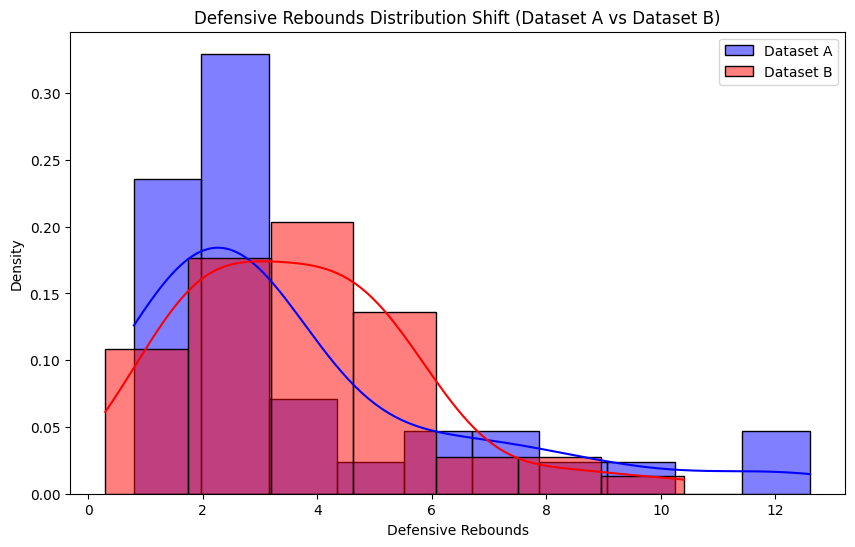


Comparing Dataset A and Dataset B for Rebounds, p-value: 0.0403


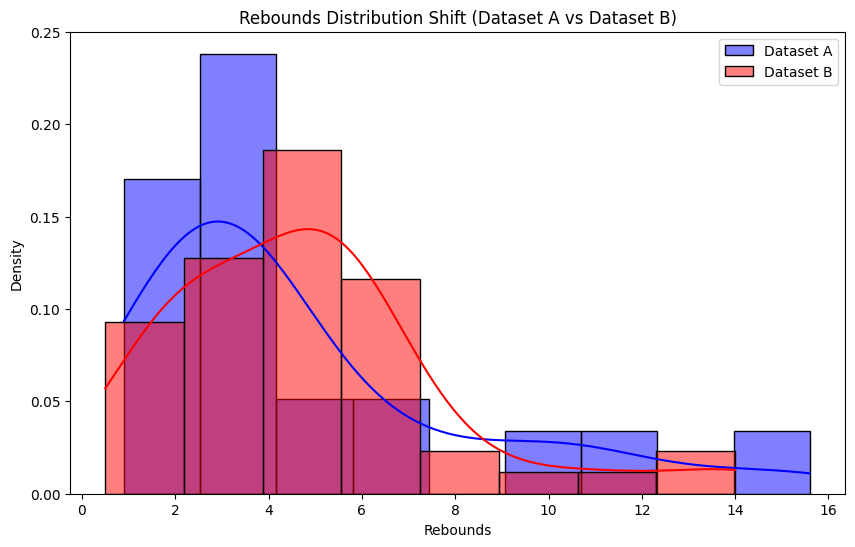


Comparing Dataset A and Dataset B for PLAYER, p-value: 0.0007


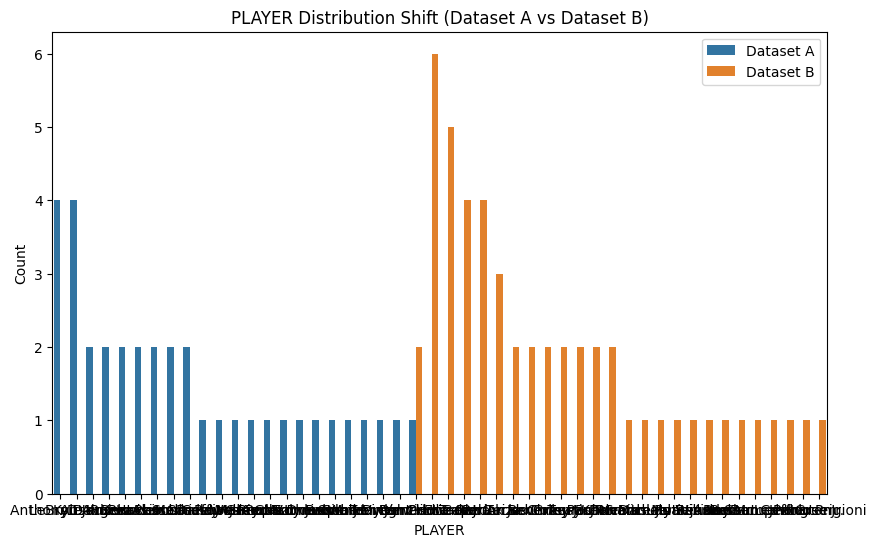


Comparing Dataset A and Dataset B for TEAM, p-value: 0.0000


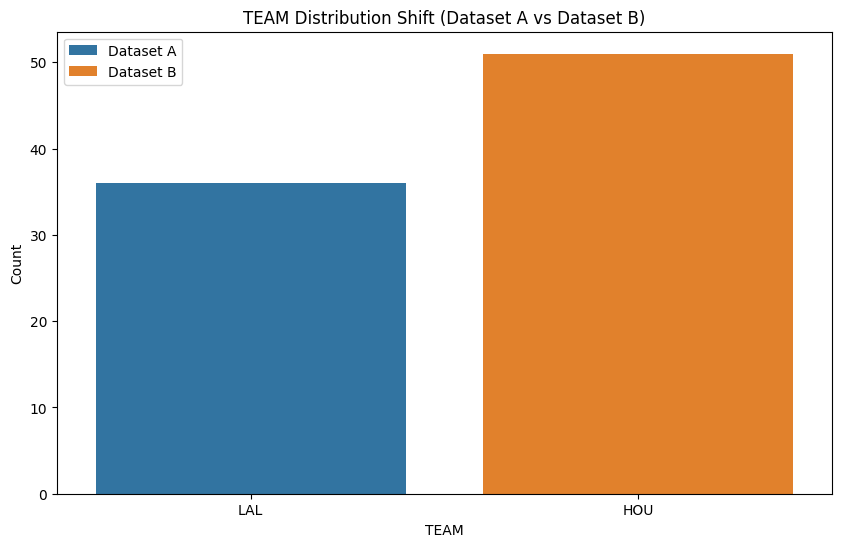


Comparing Dataset A and Dataset B for Games Played, p-value: 0.0000


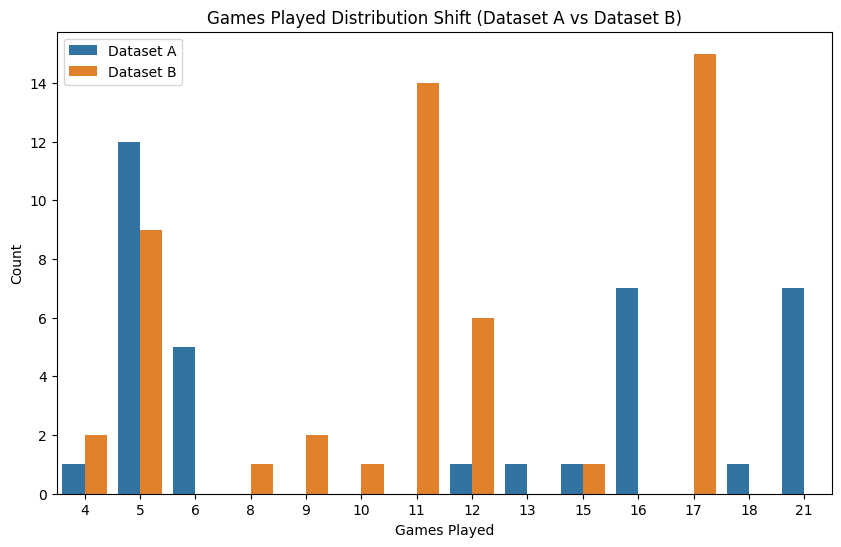


Comparing Dataset A and Dataset B for Year, p-value: 0.0000


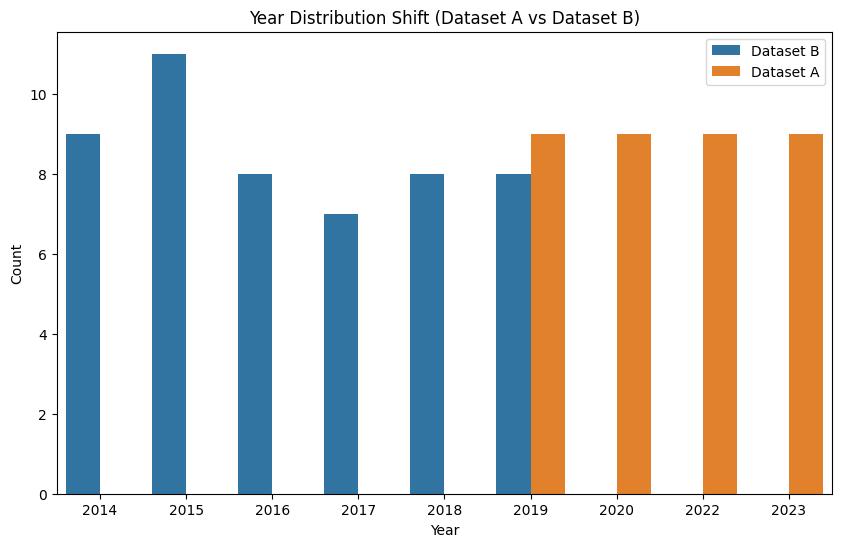


Significant shifts detected between Dataset A and Dataset B:
              Feature       p_value
0  Defensive Rebounds  4.402729e-02
1            Rebounds  4.033292e-02
2              PLAYER  6.900984e-04
3                TEAM  8.517092e-20
4        Games Played  1.491083e-07
5                Year  6.068254e-12


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
file_path_a = './Source_Target/source_data.csv'  # Adjust this path to your first CSV file location
file_path_b = './Source_Target/target_data.csv'  # Adjust this path to your second CSV file location

data_a = pd.read_csv(file_path_a)
data_b = pd.read_csv(file_path_b)

# List of continuous variables indices

continuous_variables_indices = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21] # TODO: automize this

# Detect shifts for continuous variables using KS test
def detect_continuous_shifts(data_a, data_b, feature, alpha=0.05):
    significant_shifts = []
    
    # Perform KS test
    ks_stat, p_value = ks_2samp(data_a[feature], data_b[feature])
    
    # Check if the shift is significant
    if p_value < alpha:
        significant_shifts.append((feature, p_value))
    
    return significant_shifts

# Detect significant differences for discrete variables using Chi-Square test
def detect_discrete_shifts(data_a, data_b, feature, alpha=0.05):
    significant_shifts = []
    
    data_a_counts = data_a[feature].value_counts()
    data_b_counts = data_b[feature].value_counts()
    
    # Align the series to ensure they have the same categories
    data_a_counts, data_b_counts = data_a_counts.align(data_b_counts, fill_value=0)
    
    # Create a contingency table
    contingency_table = pd.DataFrame([data_a_counts, data_b_counts])
    
    # Perform Chi-Square test
    chi2_stat, p_value, dof, ex = chi2_contingency(contingency_table)
    
    # Check if the difference is significant
    if p_value < alpha:
        significant_shifts.append((feature, p_value))
    
    return significant_shifts

# Detect shifts for each feature
all_significant_shifts = []

# Continuous variables
for index in continuous_variables_indices:
    feature = data_a.columns[index]
    shifts = detect_continuous_shifts(data_a, data_b, feature)
    all_significant_shifts.extend(shifts)

# Discrete variables (assuming all other variables are discrete)
discrete_features = [feature for feature in data_a.columns if data_a.columns.get_loc(feature) not in continuous_variables_indices]

for feature in discrete_features:
    shifts = detect_discrete_shifts(data_a, data_b, feature)
    all_significant_shifts.extend(shifts)

# Create a DataFrame for significant shifts
columns = ['Feature', 'p_value']
significant_shifts_df = pd.DataFrame(all_significant_shifts, columns=columns)

# Output the significant shifts and visualize
for feature in significant_shifts_df['Feature'].unique():
    feature_shifts = significant_shifts_df[significant_shifts_df['Feature'] == feature]
    for _, row in feature_shifts.iterrows():
        p_value = row['p_value']
        
        print(f"\nComparing Dataset A and Dataset B for {feature}, p-value: {p_value:.4f}")
        
        # Visualize the shifts
        plt.figure(figsize=(10, 6))
        if feature in data_a.columns[continuous_variables_indices]:
            sns.histplot(data_a[feature], color='blue', label='Dataset A', kde=True, stat="density")
            sns.histplot(data_b[feature], color='red', label='Dataset B', kde=True, stat="density")
            plt.xlabel(feature)
        else:
            # Create DataFrame for plotting
            data_a_df = data_a[feature].value_counts().reset_index()
            data_a_df.columns = [feature, 'Count']
            data_a_df['Dataset'] = 'Dataset A'
            
            data_b_df = data_b[feature].value_counts().reset_index()
            data_b_df.columns = [feature, 'Count']
            data_b_df['Dataset'] = 'Dataset B'
            
            plot_df = pd.concat([data_a_df, data_b_df])
            
            sns.barplot(x=feature, y='Count', hue='Dataset', data=plot_df)
            plt.xlabel(feature)
            plt.ylabel('Count')
        
        plt.title(f'{feature} Distribution Shift (Dataset A vs Dataset B)')
        plt.ylabel('Density' if feature in data_a.columns[continuous_variables_indices] else 'Count')
        plt.legend()
        plt.show()

# Display the DataFrame with significant shifts
print("\nSignificant shifts detected between Dataset A and Dataset B:")
print(significant_shifts_df)